In [1]:
import jax

from qiskit_dynamics.array import Array

from casq import PulseCircuit, PulseSolver
from casq.gates import GaussianPulseGate


In [2]:
# Configure to use JAX internally
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")


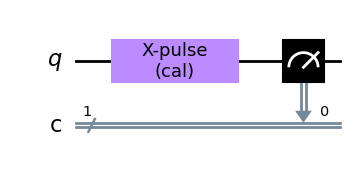

In [3]:
# Create simple circuit with Gaussian pulse as X gate
duration = 256
amplitude = 0.2
sigma = 50
x_pulse = GaussianPulseGate(duration, amplitude, sigma, name="x-pulse")
circuit = PulseCircuit(1, 1)
circuit.pulse(x_pulse, 0)
circuit.measure([0], [0])
circuit.draw("mpl")


In [4]:
solver = PulseSolver.from_backend("ibmq_manila", qubits=[0])


In [5]:
solution = solver.solve(
    run_input=circuit, steps=100, shots=1024, method="jax_odeint", atol=1e-6, rtol=1e-8, hmax=solver._dt
)


In [6]:
print(solution.counts[-1])


{'0': 561, '1': 463}
